In [46]:
import os
import math
import time
import random
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from scipy.optimize import minimize

from datetime import datetime

import argparse
from tqdm import tqdm


# Hyperparameter Tuning


In [47]:
# "DR" and "DR none"
DR_method = "DR"

# "1" and "2"
Experiment = "1"

# True and False
Visualization = False

seed_value = False
num_simulation = 100
observations = 10

In [48]:
'''
parser = argparse.ArgumentParser(description="Set parameters for the experiment.")

# Add arguments
parser.add_argument("--DR_method", choices=["DR", "DR none"], default="DR", help="Set DR method.")
parser.add_argument("--Experiment", choices=["1", "2"], default="1", help="Set experiment number.")
parser.add_argument("--Visualization", type=bool, default=False, help="Enable or disable visualization.")
parser.add_argument("--seed_value", type=int, default=False, help="Set seed value, default is False.")
parser.add_argument("--num_simulation", type=int, default="100", help="Set number of simulations.")
parser.add_argument("--observations", type=int, default="10", help="Set number of observations.")

# Parse the arguments
args = parser.parse_args()

# Assign to variables
DR_method = args.DR_method
Experiment = args.Experiment
Visualization = args.Visualization
seed_value = args.seed_value

num_simulation = args.num_simulation
observations = args.observations
'''

'\nparser = argparse.ArgumentParser(description="Set parameters for the experiment.")\n\n# Add arguments\nparser.add_argument("--DR_method", choices=["DR", "DR none"], default="DR", help="Set DR method.")\nparser.add_argument("--Experiment", choices=["1", "2"], default="1", help="Set experiment number.")\nparser.add_argument("--Visualization", type=bool, default=False, help="Enable or disable visualization.")\nparser.add_argument("--seed_value", type=int, default=False, help="Set seed value, default is False.")\nparser.add_argument("--num_simulation", type=int, default="100", help="Set number of simulations.")\nparser.add_argument("--observations", type=int, default="10", help="Set number of observations.")\n\n# Parse the arguments\nargs = parser.parse_args()\n\n# Assign to variables\nDR_method = args.DR_method\nExperiment = args.Experiment\nVisualization = args.Visualization\nseed_value = args.seed_value\n\nnum_simulation = args.num_simulation\nobservations = args.observations\n'

## Parameters

In [49]:
if seed_value:
    np.random.seed(seed_value)
    random.seed(seed_value)

# Noise parameters
sigma = 0.5
mu = np.array([-0.0, 0.0])

# Observation data and estimated mu
mu_hat = np.mean(np.random.multivariate_normal(mu, np.identity(2), observations), axis=0)
#print(mu_hat)

# Experiment parameters
max_steps = 1000
num_trajs = 500
num_vis = 500

success_time = []
success_index = []
fail_index = []

# Status
x_hists = np.zeros( (num_simulation, max_steps+1, 2) )*np.nan
gamma = [300]
T = 2.0
dt = 0.05
theta = 0.01


# Evironment Design

## Dynamics

In [50]:
class Dynamics_1:
    def __init__(self, dt, sigma):
        self.F = np.array([[1, 0, dt, 0],
                           [0, 1, 0, dt],
                           [0, 0, 1, 0],
                           [0, 0, 0, 1]])
        
        self.G = np.array([[0, 0],
                           [0, 0],
                           [sigma, 0],
                           [0, sigma]])
        
        self.S = np.array([[0, 0],
                           [0, 0],
                           [sigma, 0],
                           [0, sigma]])

    def compute_next_state(self, state, control, noise, mu, dt):
        return self.F @ state + self.G @ (control * dt) + self.S @ (mu * dt + noise * np.sqrt(dt))

In [51]:
class Dynamics_2:
    def __init__(self, dt, sigma):
        self.dt = dt

    def compute_next_state(self, state, control, noise, mu, dt):
        next_state = np.zeros_like(state)
        next_state[0] = state[0] + self.dt * (control[0] + noise[0]) * np.cos(state[2])
        next_state[1] = state[1] + self.dt * (control[0] + noise[0]) * np.sin(state[2])
        next_state[2] = state[2] + self.dt * (control[1] + noise[1])
        return next_state

## Map

In [52]:
class Obstacle:
    def __init__(self, obstacle_positions, obstacle_radius, boundary_x, boundary_y, obs_cost):
        self.obstacle_positions = np.array(obstacle_positions)
        self.obstacle_radius = np.array(obstacle_radius)
        self.obs_cost = obs_cost
        self.boundary_x = boundary_x
        self.boundary_y = boundary_y

    def compute_obstacle_cost(self, x_curr):
        num_obs = len(self.obstacle_positions)
        cost = 0
        for obs_i in range(num_obs):
            op = self.obstacle_positions[obs_i]
            cost += float(x_curr[0] > op[0] and x_curr[0] < op[0] + self.obstacle_radius[obs_i] and
                          x_curr[1] > op[1] and x_curr[1] < op[1] + self.obstacle_radius[obs_i]) * self.obs_cost
        return cost

    def compute_boundary_penalty(self, x_curr):
        return float(x_curr[0] < self.boundary_x[0] or x_curr[0] > self.boundary_x[1] or
                     x_curr[1] < self.boundary_y[0] or x_curr[1] > self.boundary_y[1]) * self.obs_cost

    def check_hit_obstacle(self, x_curr):
        for pos, r in zip(self.obstacle_positions, self.obstacle_radius):
            if (x_curr[0] > pos[0] and x_curr[0] < pos[0] + r and x_curr[1] > pos[1] and x_curr[1] < pos[1] + r):
                return True
        return False

    def check_hit_boundary(self, x_curr):
        return x_curr[0] < self.boundary_x[0] or x_curr[0] > self.boundary_x[1] or x_curr[1] < self.boundary_y[0] or x_curr[1] > self.boundary_y[1]
    
    def plot_obstacles(self, ax):
        for obs_pos, obs_r in zip(self.obstacle_positions, self.obstacle_radius):
            obs = plt.Rectangle(obs_pos, obs_r, obs_r, color='k', fill=True, zorder=6)
            ax.add_patch(obs)

class RectangularObstacle:
    def __init__(self, obstacle_positions, obstacle_dimensions, boundary_x, boundary_y, obs_cost):
        self.obstacle_positions = np.array(obstacle_positions)
        self.obstacle_dimensions = np.array(obstacle_dimensions)
        self.obs_cost = obs_cost
        self.boundary_x = boundary_x
        self.boundary_y = boundary_y

    def compute_obstacle_cost(self, x_curr):
        num_obs = len(self.obstacle_positions)
        cost = 0
        for obs_i in range(num_obs):
            op = self.obstacle_positions[obs_i]
            od = self.obstacle_dimensions[obs_i]
            cost += float(x_curr[0] > op[0] and x_curr[0] < op[0] + od[0] and
                          x_curr[1] > op[1] and x_curr[1] < op[1] + od[1]) * self.obs_cost
        return cost

    def compute_boundary_penalty(self, x_curr):
        return float(x_curr[0] < self.boundary_x[0] or x_curr[0] > self.boundary_x[1] or
                     x_curr[1] < self.boundary_y[0] or x_curr[1] > self.boundary_y[1]) * self.obs_cost

    def check_hit_obstacle(self, x_curr):
        for pos, dim in zip(self.obstacle_positions, self.obstacle_dimensions):
            if (x_curr[0] > pos[0] and x_curr[0] < pos[0] + dim[0] and x_curr[1] > pos[1] and x_curr[1] < pos[1] + dim[1]):
                return True
        return False

    def check_hit_boundary(self, x_curr):
        return x_curr[0] < self.boundary_x[0] or x_curr[0] > self.boundary_x[1] or x_curr[1] < self.boundary_y[0] or x_curr[1] > self.boundary_y[1]

    def plot_obstacles(self, ax):
        for obs_pos, obs_dim in zip(self.obstacle_positions, self.obstacle_dimensions):
            obs = plt.Rectangle(obs_pos, obs_dim[0], obs_dim[1], color='k', fill=True, zorder=6)
            ax.add_patch(obs)


class CircleObstacle(Obstacle):
    def __init__(self, obstacle_positions, obstacle_radius, boundary_x, boundary_y, obs_cost):
        super().__init__(obstacle_positions, obstacle_radius, boundary_x, boundary_y, obs_cost)

    def compute_obstacle_cost(self, x_curr):
        num_obs = len(self.obstacle_positions)
        cost = 0
        for obs_i in range(num_obs):
            op = self.obstacle_positions[obs_i]
            distance_to_center = np.sqrt((x_curr[0] - op[0])**2 + (x_curr[1] - op[1])**2)
            cost += float(distance_to_center <= self.obstacle_radius[obs_i]) * self.obs_cost
        return cost

    def plot_obstacles(self, ax):
        for obs_pos, obs_r in zip(self.obstacle_positions, self.obstacle_radius):
            obs = plt.Circle(obs_pos, obs_r, color='k', fill=True, zorder=6)
            ax.add_patch(obs)

class PolygonObstacle(Obstacle):
    def __init__(self, obstacle_positions, boundary_x, boundary_y, obs_cost):
        # Here, obstacle_positions should be a list of vertices for each polygon
        super().__init__(obstacle_positions, None, boundary_x, boundary_y, obs_cost)

    def compute_obstacle_cost(self, x_curr):
        num_obs = len(self.obstacle_positions)
        cost = 0
        for obs_i in range(num_obs):
            polygon = Polygon(self.obstacle_positions[obs_i])
            cost += float(polygon.contains_point(x_curr)) * self.obs_cost
        return cost

    def plot_obstacles(self, ax):
        for obs_pos in self.obstacle_positions:
            obs = Polygon(obs_pos, color='k', fill=True, zorder=6)
            ax.add_patch(obs)

class Map:
    def __init__(self, obstacles):
        self.obstacles = obstacles

    def compute_total_obstacle_cost(self, x_curr):
        total_cost = 0
        for obstacle in self.obstacles:
            total_cost += obstacle.compute_obstacle_cost(x_curr)
        return total_cost

    def compute_total_boundary_penalty(self, x_curr):
        total_penalty = 0
        for obstacle in self.obstacles:
            total_penalty += obstacle.compute_boundary_penalty(x_curr)
        return total_penalty

    def check_hit_any_obstacle(self, x_curr):
        for obstacle in self.obstacles:
            if obstacle.check_hit_obstacle(x_curr):
                return True
        return False

    def check_hit_any_boundary(self, x_curr):
        for obstacle in self.obstacles:
            if obstacle.check_hit_boundary(x_curr):
                return True
        return False

    def plot_map(self, ax):
        for obstacle in self.obstacles:
            obstacle.plot_obstacles(ax)


## Experiment setting

In [53]:
# Create the Experiment

if Experiment == "1":
    # Dynamics
    dynamics = Dynamics_1(dt, sigma)
    
    x_goal = np.array([0,0])
    x_init = np.array([-3.5, 2.5, 0, 0])
    
    # Map parameters
    boundary_x = [-4.0, 1.0]
    boundary_y = [-1.0, 4.0]
    obs_cost = 1e2
    goal_tolerance = 0.1
    dist_weight = 0.01
    obstacle_positions = np.array([[-2.5, 0.0]])
    obstacle_radius = np.array([2.0])

    obstacle = Obstacle(obstacle_positions = obstacle_positions, obstacle_radius = obstacle_radius, boundary_x = boundary_x, boundary_y = boundary_y, obs_cost = obs_cost)
    circle_obstacle = CircleObstacle(obstacle_positions = np.array([[-2.0, 0.5]]), obstacle_radius = np.array([1.0]), 
                                    boundary_x = boundary_x, boundary_y = boundary_y, obs_cost = obs_cost)

    obstacle1 = Obstacle(obstacle_positions=np.array([[-2.75, 0.25]]), obstacle_radius=np.array([2.0]), 
                        boundary_x=boundary_x, boundary_y=boundary_y, obs_cost=obs_cost)

    obstacle2 = Obstacle(obstacle_positions=np.array([[0.0, -2.5]]), obstacle_radius=np.array([1.0]), 
                        boundary_x=boundary_x, boundary_y=boundary_y, obs_cost=obs_cost)
    environment = Map([obstacle1])

elif Experiment == "2":

    # Dynamics
    dynamics = Dynamics_2(dt, sigma)
    
    x_goal = np.array([0,0])
    x_init = np.array([0, 0.5, 5.7, 0])
    
    # Map parameters
    boundary_x = [-0.2, 0.4]
    boundary_y = [-0.2, 0.6]
    obs_cost = 1e2
    goal_tolerance = 0.01
    dist_weight = 0.01
    obstacle_positions = np.array([[-0.1, 0.3]])
    obstacle_radius = np.array([[0.2, 0.1]])

    obstacle = RectangularObstacle(obstacle_positions = obstacle_positions, obstacle_dimensions = obstacle_radius,
                                    boundary_x = boundary_x, boundary_y = boundary_y, obs_cost = obs_cost)
    environment = Map([obstacle])

else:
    raise ValueError("Experiment number not recognized")


# Algorithm

## Sampling

In [54]:
def sample_noise(T=10.0, dt=0.5, num_trajs=500, n=2) :
    time_steps = math.floor(T/dt)
    noise_samples = np.random.multivariate_normal(mu, np.identity(2) , [num_trajs,time_steps])
    return noise_samples

## Rollout 

In [55]:
def stage_cost(dist2, dist_weight = 1) :
    return dist_weight * dist2

def term_cost(dist2, goal_reached) :
    return (1 - float(goal_reached)) * dist2

def dist_to_goal_function(x_curr, x_goal):
    return np.linalg.norm(x_curr - x_goal)

def rollout(x_init, x_goal, u_curr, obs_pos, obs_r, T, dt, theta, noise_samples, dist_weight, sigma, mu_hat, obs_cost = 10, num_trajs=500, num_vis=500, goal_tolerance=0.1) :
    costs = np.zeros(num_trajs)
    time_steps = int(T//dt)
    goal_reached = False
    
    x_vis = np.zeros( (num_vis, time_steps, 2) )*np.nan
    n = len(x_init)
    
    for k in range(num_trajs) :

        x_curr = x_init.copy()
        
        if k < num_vis :
            x_vis[k, 0, :] = x_curr[:2]    
        
        for t in range(time_steps) :
            x_curr = dynamics.compute_next_state(x_curr, np.zeros(2), noise_samples[k, t, :], mu_hat, dt)
            
            if k < num_vis :
                x_vis[k, t, :] = x_curr[:2]    
                

            dist_to_goal = dist_to_goal_function(x_curr[:2], x_goal)
            costs[k] += stage_cost(dist_to_goal, dist_weight)
            
            if dist_to_goal <= goal_tolerance :
                goal_reached = True
                break
            
            num_obs = len(obs_pos)
            
            if num_obs != 0 :
                # Obstacle cost
                costs[k] += environment.compute_total_obstacle_cost(x_curr)
                if environment.check_hit_any_obstacle(x_curr):
                    break

                
                # Boundary panalty
                costs[k] += environment.compute_total_boundary_penalty(x_curr)
                if environment.check_hit_any_boundary(x_curr):
                    break
            
            # Terminal cost
            # costs[k] += term_cost(dist_to_goal, goal_reached) 
            
            # for t in range(time_steps) :
            #     costs[k] += u_curr[t,:] @ Sigma @ u_curr[t,:]
    return costs, x_vis

## Optimization

In [56]:
def opt_cost_func(lambda_, gamma, costs, num_trajs):
    lambda_prime = 1 / (1 - lambda_)
    return gamma / lambda_ + 1/lambda_prime * np.log(1/num_trajs * np.sum(np.exp(-costs * lambda_prime)))

In [57]:
def update_useq_risk_neutral(costs, u_curr, noise_samples, T, dt, sigma, lambda_neut=1, n=2) :
    costs = np.exp( - (costs) / lambda_neut )     
    sum_costs = np.sum(costs)    
    
    time_steps = math.floor(T/dt)
    u_curr = np.zeros((time_steps,n))
    for t in range(time_steps) :
        for k in range(len(costs)) :
            u_curr[t,:] += (costs[k] / sum_costs ) * noise_samples[k,t,:] / np.sqrt(dt) 

    return  u_curr

In [58]:
def update_useq_NM(costs, u_curr, noise_samples, gammas, T, dt):
    num_trajs = len(noise_samples)
    lambda_r = 1  # Initialize lambda_r

    for gamma in gammas:
        best_result = None
        best_value = float('inf')  # Initialize to positive infinity for minimization
        best_method = None
        
        # methods = ['Powell', 'CG', 'BFGS', 'L-BFGS-B', 'TNC', 'COBYLA', 'SLSQP']
        methods = ['Powell', 'L-BFGS-B', 'TNC', 'COBYLA', 'SLSQP']
        bound_for_lambda = [(0, None)]  # This sets the lower bound to 0 and no upper bound

        for method in methods:
            try:
                result = minimize(opt_cost_func, x0=lambda_r, args=(gamma, costs, num_trajs), method=method, bounds=bound_for_lambda)
                
                # Compare result.fun even if result.success is False
                if result.fun < best_value:
                    best_result = result
                    best_value = result.fun
                    best_method = method
            except ValueError as e:
                print(f"Error using method {method} for gamma = {gamma}: {e}")
        
        if best_result:  # If we found a result (regardless of success status)
            lambda_r = best_result.x[0]
            #print(f"For gamma = {gamma}, best method is {best_method} with value {best_value}.")
        else:
            print("Optimization failed for gamma =", gamma)

    # Return the best lambda_r found
    return update_useq_risk_neutral(costs, u_curr, noise_samples, T, dt, sigma, lambda_neut=lambda_r, n=2)

## Path Integral

In [59]:
def path_integral(x_init, x_goal, u_curr, dist_weight, obs_cost, obs_pos, obs_r, T, dt, theta, num_trajs, num_vis, init_report, gammas, sigma):
    
    noise_samples = sample_noise(T, dt, num_trajs, n=2)
    costs, x_vis = rollout(x_init, x_goal, u_curr, obs_pos, obs_r, T, dt, theta, noise_samples, dist_weight, sigma, mu_hat, obs_cost, num_trajs, num_vis, goal_tolerance=0.1)   
    if DR_method == "DR" :
        u_curr = update_useq_NM(costs, u_curr, noise_samples, gammas, T, dt)
    elif DR_method == "DR none" :
        u_curr = update_useq_risk_neutral(costs, u_curr, noise_samples, T, dt, sigma, lambda_neut=1, n=2)
    else :
        raise ValueError("DR_method not recognized")
    return u_curr, x_vis

# Simulation

In [60]:
for k in tqdm(range(num_simulation), desc="Simulating", unit="sim"):
    
    # Initial status
    terminate = False
    hit_obstacle = False
    hit_boundary = False

    u_curr = np.zeros((int(T//dt), 2))
    x_hist = np.zeros( (max_steps+1, 4) )*np.nan
    u_hist = np.zeros( (max_steps+1, 2) )*np.nan
    x_hist[0] = x_init
    
    plot_every_n = 10

    for t in range(max_steps) :
        u_curr, x_vis = path_integral(x_hist[t], x_goal, u_curr, dist_weight, 
                               obs_cost, obstacle_positions, obstacle_radius, 
                               T, dt, theta, num_trajs, num_vis, init_report=t, gammas=gamma, sigma=sigma)
        u_hist[t] = u_curr[0]  
        
        x_hist[t+1] = dynamics.compute_next_state(x_hist[t], u_curr[0], np.random.multivariate_normal(np.zeros(2), np.identity(2)), mu, dt)
        
        # Obstacles check
        if environment.check_hit_any_obstacle(x_hist[t+1]):
            terminate = True
            fail_index.append(k)
            print("Hit obstacle")
            break
        
        # Boundary check
        if environment.check_hit_any_boundary(x_hist[t+1]):
            terminate = True
            fail_index.append(k)
            print("Hit boundary")
            break    

        # Goal check
        if dist_to_goal_function(x_hist[t+1, :2], x_goal) <= goal_tolerance :
            print("Goal reached at t={:.2f}s".format(t*dt))
            success_time.append(t*dt)
            terminate = True
            success_index.append(k)
            break
        
        # Max steps check
        if t == max_steps - 1:
            terminate = True
            fail_index.append(k)
            print("MAX STEPS REACHED")
            break  

        # Trajectory plot
        if Visualization:
            if t % plot_every_n == 0 :

                # Visualize the basic setup
                fig, ax = plt.subplots()
                ax.plot([x_init[0]], [x_init[1]], '8', markersize = 10, markerfacecolor = 'k', label = 'Initial State',markeredgecolor = 'none' )
                ax.plot([x_goal[0]], [x_goal[1]], '*', markersize = 10, markerfacecolor = 'k', label = 'Target State',markeredgecolor = 'none' )
                
                # Show obstacles
                environment.plot_map(ax)

                # Track the realized trajectoy
                ax.plot(x_hist[:,0], x_hist[:,1], 'r', label='Past state')
                
                # Get rollout states from subset of maps for visualization
                ax.plot(x_vis[:,:,0].T, x_vis[:,:,1].T, 'k', alpha=0.1, zorder=3)
                
                ax.set_xlim(boundary_x)
                ax.set_ylim(boundary_y)
                
                # ax.legend(loc='lower left')
                ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
                ax.set_aspect('equal')
                plt.tight_layout()
                # plt.savefig(f'simulation\plot_{t}.png')
                plt.show()
            
    x_hists[k, :t, :] = x_hist[:t, :2]

    # Full trajectory plot
    if Visualization:
        if terminate:
            fig, ax = plt.subplots()
            ax.plot([x_init[0]], [x_init[1]], '8', markersize=20, markerfacecolor='lime', label='Initial State', markeredgecolor='k', zorder=6)
            ax.plot([x_goal[0]], [x_goal[1]], '*', markersize=20, markerfacecolor='lime', label='Target State', markeredgecolor='k', zorder=6)
            environment.plot_map(ax)

            ax.plot(x_hist[:,0], x_hist[:,1], 'r', label='Past state')
            ax.set_xlim(boundary_x)
            ax.set_ylim(boundary_y)
            ax.set_xlabel(r'$p_{x}$')
            ax.set_ylabel(r'$p_{y}$')
            plt.gcf().set_dpi(600)
            ax.set_title(f'Trajectories {k+1} in {num_simulation} simulations.')
            ax.set_aspect('equal')
            plt.tight_layout()
            plt.show()
   

Simulating:   0%|          | 0/100 [00:00<?, ?sim/s]/var/folders/t3/2c1kbnd505j_ylmc4_yw3ry00000gq/T/ipykernel_37777/3702975592.py:2: RuntimeWarning: divide by zero encountered in divide
  lambda_prime = 1 / (1 - lambda_)
/var/folders/t3/2c1kbnd505j_ylmc4_yw3ry00000gq/T/ipykernel_37777/3702975592.py:3: RuntimeWarning: divide by zero encountered in log
  return gamma / lambda_ + 1/lambda_prime * np.log(1/num_trajs * np.sum(np.exp(-costs * lambda_prime)))
/var/folders/t3/2c1kbnd505j_ylmc4_yw3ry00000gq/T/ipykernel_37777/3702975592.py:3: RuntimeWarning: invalid value encountered in multiply
  return gamma / lambda_ + 1/lambda_prime * np.log(1/num_trajs * np.sum(np.exp(-costs * lambda_prime)))
/var/folders/t3/2c1kbnd505j_ylmc4_yw3ry00000gq/T/ipykernel_37777/3702975592.py:3: RuntimeWarning: overflow encountered in exp
  return gamma / lambda_ + 1/lambda_prime * np.log(1/num_trajs * np.sum(np.exp(-costs * lambda_prime)))
Simulating:   1%|          | 1/100 [00:12<20:24, 12.37s/sim]

Hit obstacle


Simulating:   2%|▏         | 2/100 [01:18<1:12:02, 44.11s/sim]

Goal reached at t=14.70s


Simulating:   2%|▏         | 2/100 [01:31<1:15:03, 45.95s/sim]


KeyboardInterrupt: 

/Users/Shared/anaconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/Shared/anaconda3/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


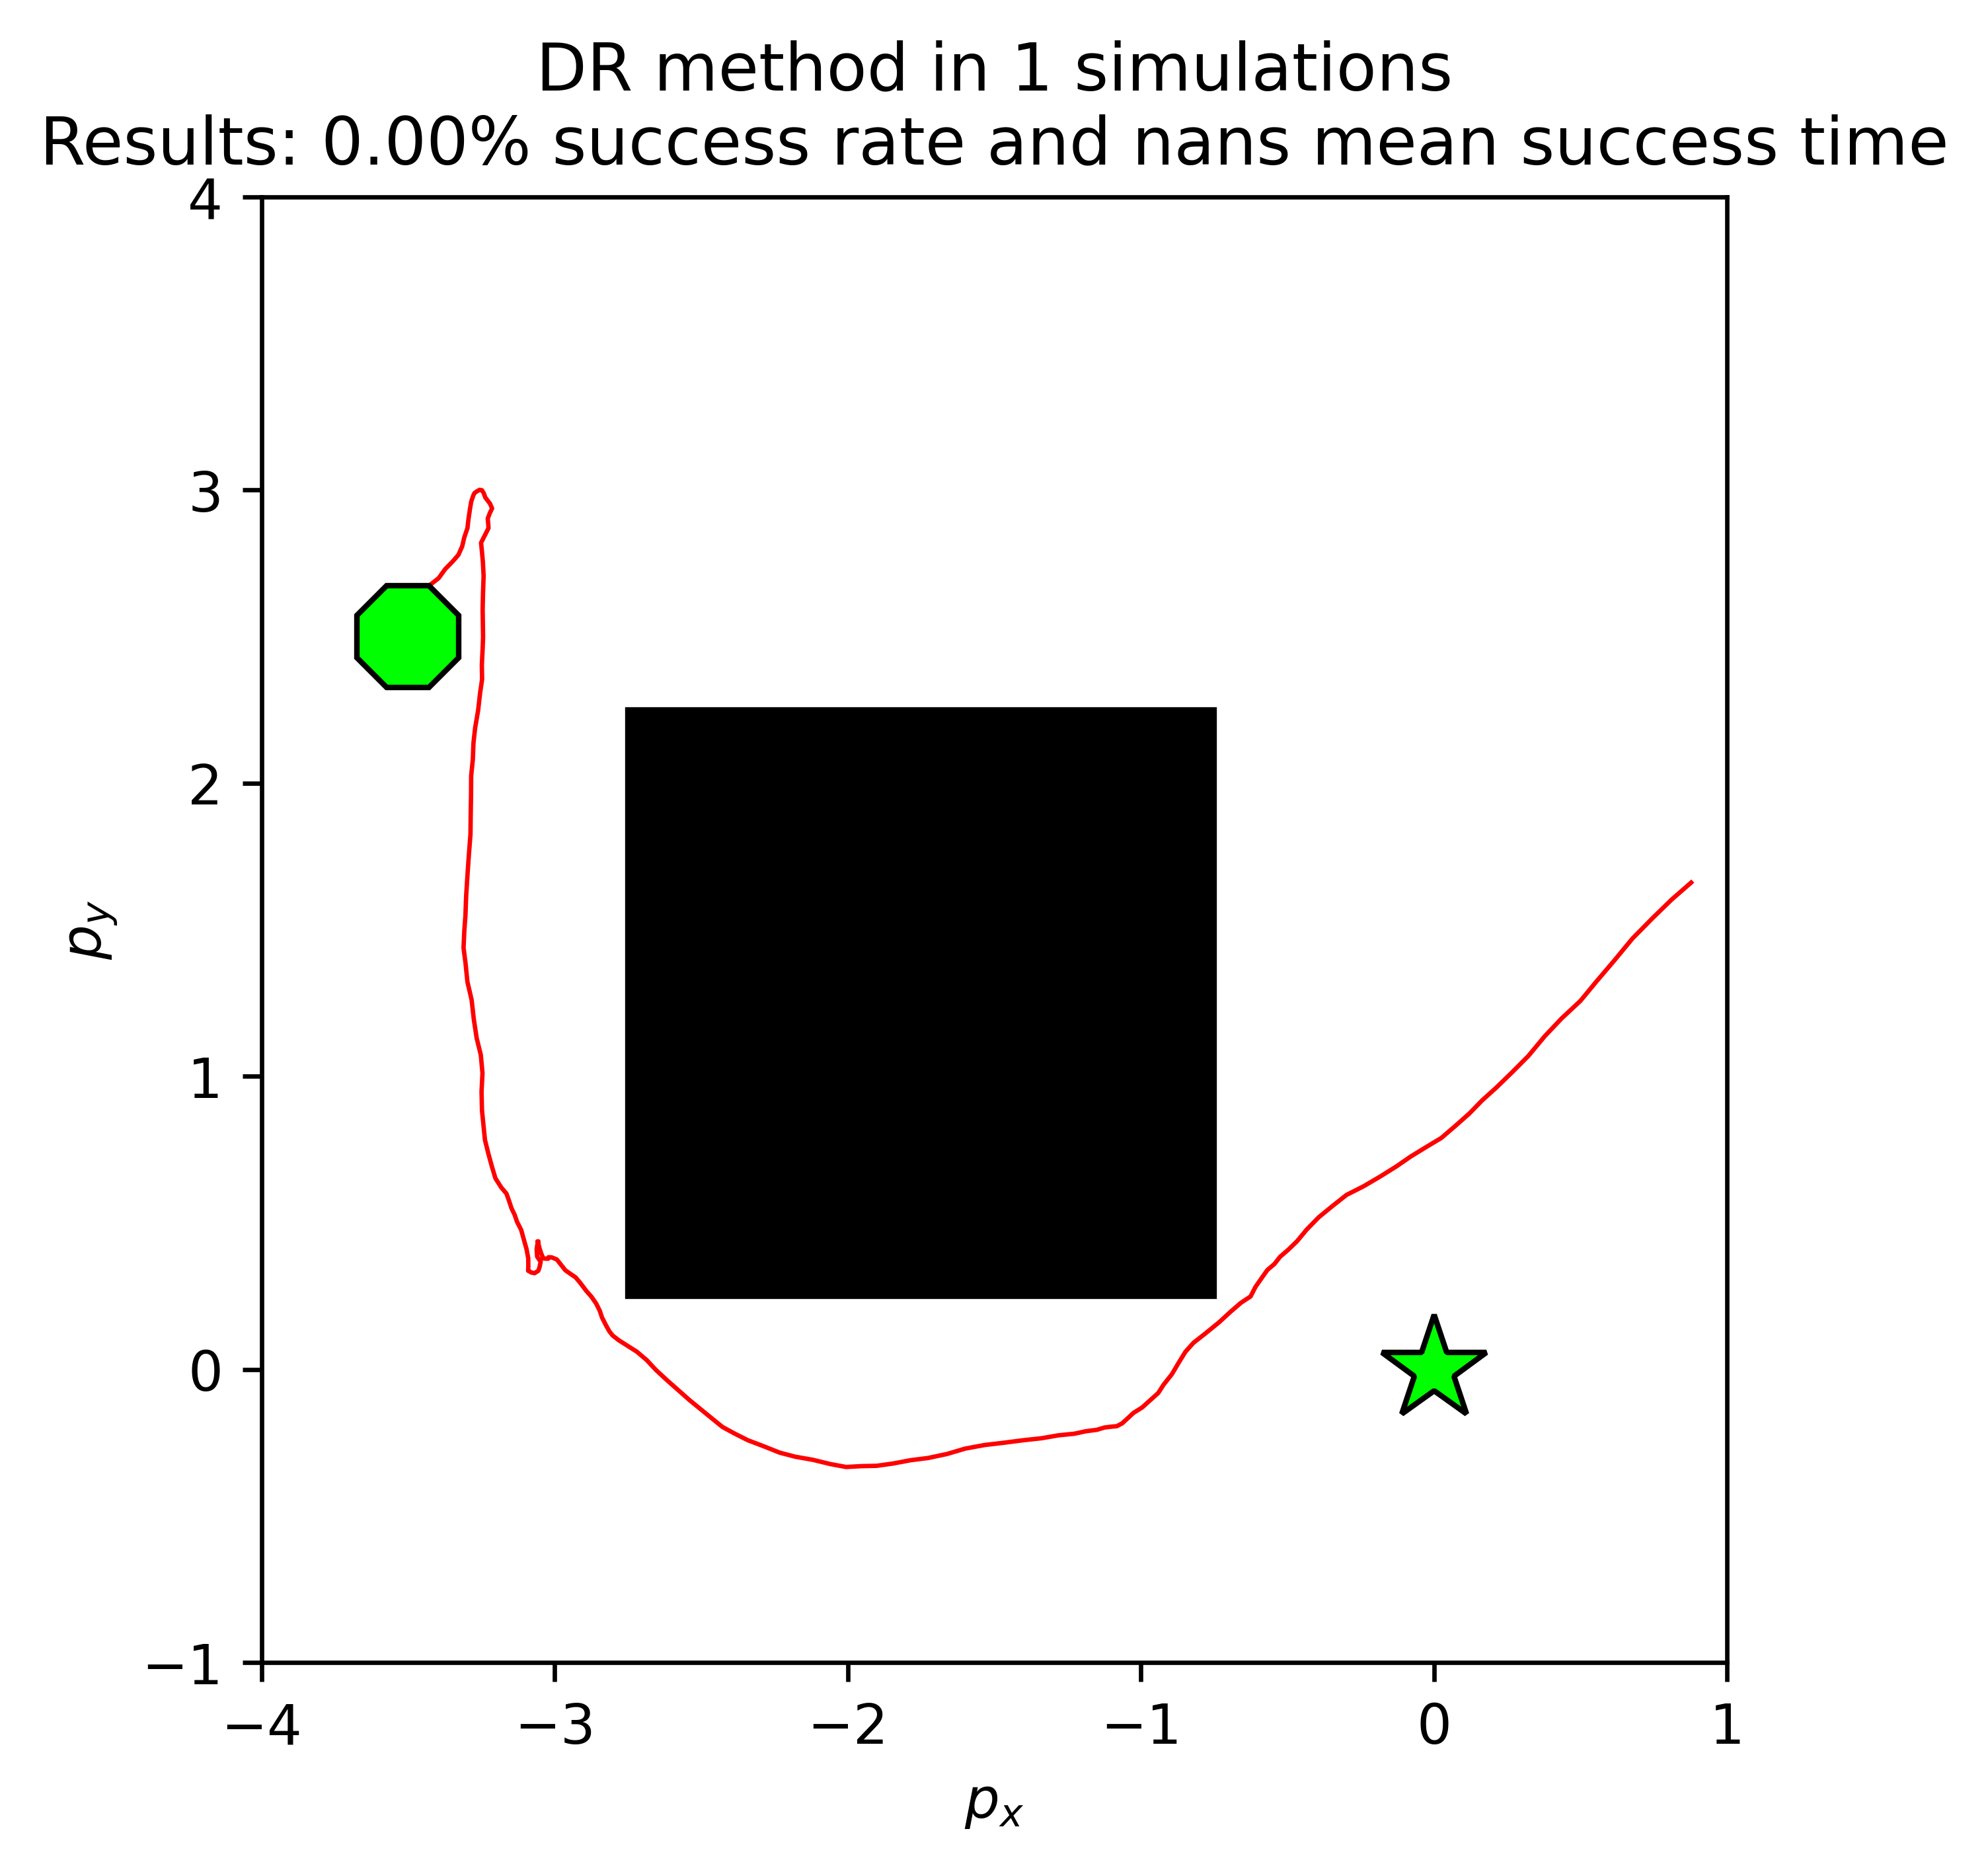

In [ ]:
# Final Vis and Log Save
fig, ax = plt.subplots()
ax.plot([x_init[0]], [x_init[1]], '8', markersize=20, markerfacecolor='lime', label='Initial State', markeredgecolor='k', zorder=6)
ax.plot([x_goal[0]], [x_goal[1]], '*', markersize=20, markerfacecolor='lime', label='Target State', markeredgecolor='k', zorder=6)
environment.plot_map(ax)
#obstacle.plot_obstacles(ax)

ax.set_xlim(boundary_x)
ax.set_ylim(boundary_y)
ax.set_xlabel(r'$p_{x}$')
ax.set_ylabel(r'$p_{y}$')
plt.gcf().set_dpi(600)
ax.set_aspect('equal')

ax.plot(x_hists[success_index,:,0].T, x_hists[success_index,:,1].T, 'b', linewidth=0.8)
ax.plot(x_hists[fail_index,:,0].T, x_hists[fail_index,:,1].T, 'r', linewidth=0.8)
#ax.plot(x_hists[:,:,0].T, x_hists[:,:,1].T, 'y', linewidth=0.8)
# Set the main title
title_line1 = f'{DR_method} method in {num_simulation} simulations'
title_line2 = f'Results: {len(success_index)/num_simulation*100:.2f}% success rate and {np.mean(success_time):.2f}s mean success time'
ax.set_title(f"{title_line1}\n{title_line2}")
if Visualization:
    plt.show()

In [ ]:
# Save the log
dir_path = f"./log/{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}"
if not os.path.exists(dir_path):
    os.makedirs(dir_path)

file_path = os.path.join(dir_path, 'x_hists.json')

with open(file_path, 'w') as file:
    json.dump(x_hists.tolist(), file)

df = pd.DataFrame({'success_index': success_index, 'success_time': success_time})

df.to_csv(os.path.join(dir_path, 'success_data.csv'), index=False)
filename = os.path.join(dir_path, f"plot_mu_hat{mu_hat}.png")
os.makedirs(os.path.dirname(filename), exist_ok=True)
fig.savefig(filename)